# Header


In [1]:
from networkClasses import *
from classSupport import *
from methodSupport import *

import autograd.numpy as anp
from autograd import grad,elementwise_grad
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

## Random seed
def_seed = 1
np.random.seed(def_seed); anp.random.seed(def_seed)

## Figure defaults
plt.rcParams["figure.figsize"] = (8,3); plt.rcParams["font.size"] = 10

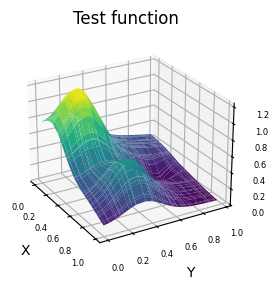

In [2]:
anp.random.seed(def_seed)
cases = ['1D','2D','Franke']
case_ = cases[2]
show = True #True False

# Grid and data setup
a      = [1.0, 1.5, 1.2]                                   # Coefficients for exponential model
c0, c1 = 0.2, 0.95                                         # Noise scaling    
x0, xN = 0, 1                                              # Start and end of domain, x-axis
y0, yN = 0, 1                                              # Start and end of domain, y-axis
Nx, Ny = 50, 50                                            # Number of sample points

dataset = Initializer(problem_case=case_,sample_size=[Nx,Ny])
dataset.domain_setup(noise=c0)
dataset.test_function(a)
if case_ == '1D':
    f = dataset.plot(labels=['Test function','x','y','dataset','true'])
else:
    f = dataset.plot(labels=['Test function','X','Y','Z'])

if case_ == '1D':
    targets = dataset.target[0]
    inputs = dataset.x

else:
    targets = dataset.target_f
    x = dataset.xf; y = dataset.yf
    inputs = anp.zeros((x.shape[0],2))
    inputs[:,0] = x[:,0]
    inputs[:,1] = y[:,0] 

test_size = 1/5
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs,targets,test_size=test_size,random_state=def_seed)
#inputs_train, inputs_test, targets_train, targets_test = inputs,inputs,targets,targets
## Data scaling
scaler = StandardScaler() #StandardScaler() MinMaxScaler()
scaler.fit(inputs_train)
scale = False
if scale == True:
    inputs_train_s = scaler.transform(inputs_train)
    inputs_test_s = scaler.transform(inputs_test)
else:
    inputs_train_s = inputs_train
    inputs_test_s = inputs_test

#### Grid search for $\eta$ and $\lambda$ parameters, `ADAM`-method

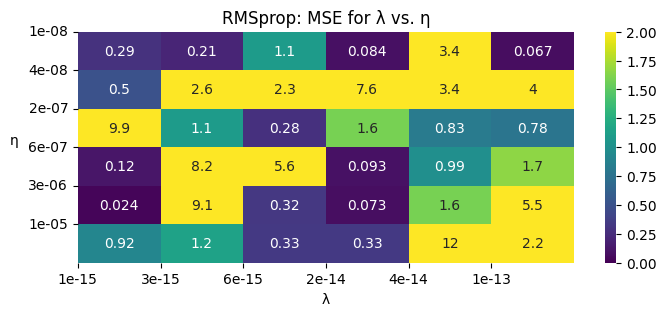

In [ ]:
anp.random.seed(def_seed)

n_inputs,n_features = inputs_train_s.shape

layer_output_sizes = [5,5,1]

hidden_func  = sigmoid #sigmoid ReLU, expReLU, LeakyReLU,identity
hidden_der = sigmoid_der #elementwise_grad(hidden_func,0)

act_funcs = []; act_ders = []
for i in range(len(layer_output_sizes)-1):
    act_funcs.append(hidden_func)
    act_ders.append(hidden_der)
act_funcs.append(identity); 
output_der = identity #elementwise_grad(act_funcs[-1],0);
act_ders.append(output_der)

cost_func = mse_predict
cost_der  = grad(cost_func,0)

network = FFNNetwork(network_input_size=n_features,layer_output_size=layer_output_sizes,
                         activation_functions=act_funcs,activation_derivatives=act_ders,
                         cost_function=cost_func,cost_derivative=cost_der)
network.reset()
network.create_layers()

## Gradient Descent setup
num_param = 6
eta = anp.logspace(-8,-1,num_param)
lmbda = anp.logspace(-15,-10,num_param); lp = 2
gamma = 1e-8
adagrad_mom = gamma
decay_rms = 0.9
ADAM_decay = [0.9, 0.99]

batches = 32; epoch = 1000

MSE_NN = anp.zeros((len(eta),len(lmbda)))
r2_NN = anp.zeros_like(MSE_NN)
show = False
for i in range(len(eta)):
    for j in range(len(lmbda)):
        
        ## Recreating the layers
        network.create_layers()
        
        ## Calling GDMethod with new parameters
        #GDMethod = PlainGD(eta[i],lmbda=lmbda[j],lp=lp)
        #GDMethod = MomentumGD(eta[i],gamma,lmbda=lmbda[j],lp=lp)
        #GDMethod = Adagrad(eta[i],adagrad_mom,lmbda=lmbda[j],lp=lp)
        GDMethod = RMSprop(eta[i],decay=decay_rms,lmbda=lmbda[j])
        #GDMethod = ADAM(eta[i],ADAM_decay,lmbda=lmbda[j])

        network.train_network(inputs_train_s,targets_train,GDMethod,batches=batches,epochs=epoch)

        final_predict = network.feed_forward(inputs_test_s)
        
        MSE_NN[i,j] = mse_predict(final_predict,targets_test)
        r2_NN[i,j] = network.score(inputs_test_s,targets_test)
        if show == True:
            print(f'Method: {GDMethod.__class__.__name__}')
            print('Regularization, λ:',lmbda[j])
            print('Learning rate,  η:',eta[i])
            print('MSE: ',mse_predict(final_predict,targets_test))

        network.reset()

#MSE_NN = anp.nan_to_num(MSE_NN,nan=1)

fig,ax = lambda_eta(MSE_NN,[lmbda,eta],
                    axis_tick_labels=[[f'{y:.0e}' for y in lmbda],[f'{y:.0e}' for y in eta]],
                    cbar_lim=[0.,2.]
                    )
_ = ax.set_title(f'{GDMethod.__class__.__name__}: MSE for λ vs. η')#\nγ = %.0e'%(gamma))

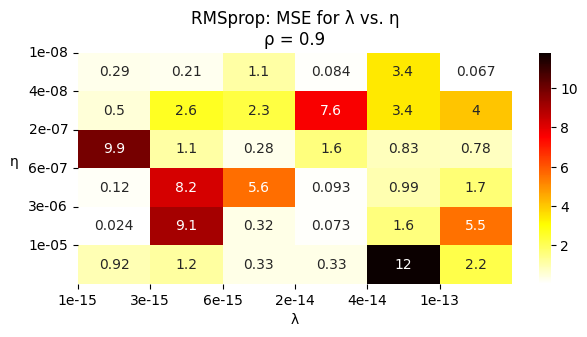

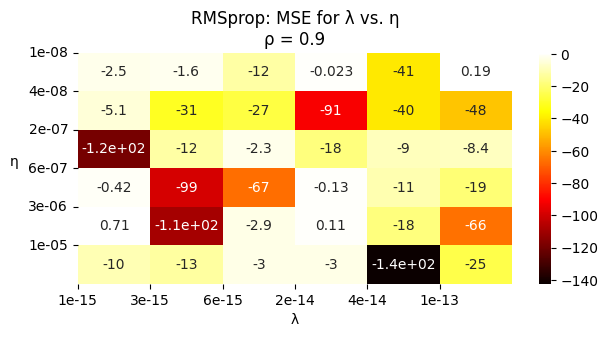

In [27]:
fig,ax = lambda_eta(MSE_NN,[lmbda,eta],
                    axis_tick_labels=[[f'{y:.0e}' for y in lmbda],[f'{y:.0e}' for y in eta]],
                    cbar_lim=[MSE_NN.min(),MSE_NN.max()],
                    #cbar_lim=[0.0,4.],
                    cmap='hot_r'#,save=True,f_name='grid_search_eta_lamb_ADAM_linreg.png'  #hot
                    )
fig.set_size_inches(7,3)
#ax.set_xlabel('ρ')
#_ = ax.set_title(f'{GDMethod.__class__.__name__}: MSE for λ vs. η\nρ = (%g, %g)' %(ADAM_decay[0],ADAM_decay[1]))
_ = ax.set_title(f'{GDMethod.__class__.__name__}: MSE for λ vs. η\nρ = %g' %(decay_rms))
#_ = ax.set_title(f'{GDMethod.__class__.__name__}: MSE for λ vs. η\nγ = %.0e' %(gamma))  #ρ = (%g, %g)' %(ADAM_decay[0],ADAM_decay[1]))
fig1,bx = lambda_eta(r2_NN,[lmbda,eta],
                    axis_tick_labels=[[f'{y:.0e}' for y in lmbda],[f'{y:.0e}' for y in eta]],
                    cbar_lim=[r2_NN.min(),r2_NN.max()],
                    #cbar_lim=[0.0,4.],
                    cmap='hot'#,save=True,f_name='grid_search_eta_lamb_ADAM_linreg.png'  #hot
                    )
fig1.set_size_inches(7,3)
#ax.set_xlabel('ρ')
#_ = bx.set_title(f'{GDMethod.__class__.__name__}: MSE for λ vs. η\nρ = (%g, %g)' %(ADAM_decay[0],ADAM_decay[1]))
_ = bx.set_title(f'{GDMethod.__class__.__name__}: MSE for λ vs. η\nρ = %g' %(decay_rms))
#_ = bx.set_title(f'{GDMethod.__class__.__name__}: R²-Score for λ vs. η\nγ = %.0e' %(gamma))   #ρ = (%g, %g)' %(ADAM_decay[0],ADAM_decay[1]))

In [28]:
fig.savefig('grid_search_eta_lamb_rms_linreg_m32_e1000_smaller_range.png',dpi=300,bbox_inches='tight')
fig1.savefig('grid_search_r2_eta_lamb_rms_linreg_m32_e1000_smaller_range.png',dpi=300,bbox_inches='tight')

#### $\eta$ and $\gamma$ for `Adagrad`-method

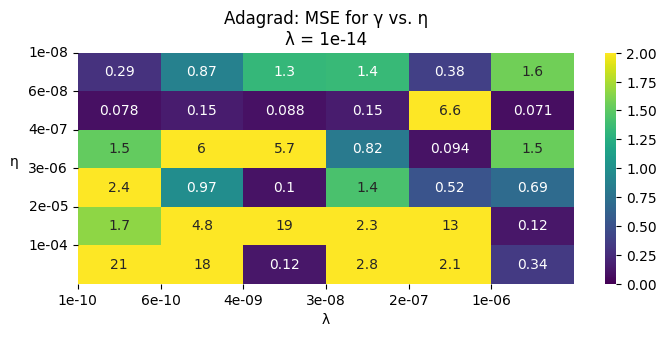

In [12]:
network.reset()
network.create_layers()

## Gradient Descent setup
num_param = 6
eta = anp.logspace(-8,-4,num_param)
gamma = anp.logspace(-10,-6,num_param)
lmbda = 1e-14; lp = 2
adagrad_mom = gamma
decay_rms = 0.9
ADAM_decay = [0.9, 0.99]

batches = 32; epoch = 1000

MSE_NN = anp.zeros((len(eta),len(gamma)))
for i in range(len(eta)):
    for j in range(len(gamma)):
        ## Recreating the layers
        network.create_layers()
        
        ## Calling GDMethod with new parameters
        GDMethod = Adagrad(eta[i],momentum=gamma[j],lmbda=lmbda,lp=lp)

        network.train_network(inputs_train_s,targets_train,GDMethod,batches=batches,epochs=epoch)

        final_predict = network.feed_forward(inputs_test_s)
        
        MSE_NN[i,j] = mse_predict(final_predict,targets_test)
        if show == True:
            print(f'Method: {GDMethod.__class__.__name__}')
            print('Regularization, λ:',lmbda[j])
            print('Learning rate,  η:',eta[i])
            print('MSE: ',mse_predict(final_predict,targets_test))

        network.reset()

#MSE_NN = anp.nan_to_num(MSE_NN,nan=1)

fig,ax = lambda_eta(MSE_NN,[gamma,eta],
                    axis_tick_labels=[[f'{y:.0e}' for y in gamma],[f'{y:.0e}' for y in eta]],
                    cbar_lim=[0.,2.]
                    )
_ = ax.set_title(f'{GDMethod.__class__.__name__}: MSE for γ vs. η\nλ = %.0e'%(lmbda))

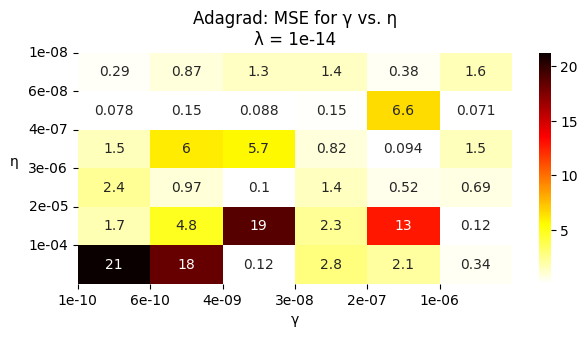

In [14]:
fig,ax = lambda_eta(MSE_NN,[gamma,eta],
                    axis_tick_labels=[[f'{y:.0e}' for y in gamma],[f'{y:.0e}' for y in eta]],
                    cbar_lim=[MSE_NN.min(),MSE_NN.max()],
                    #cbar_lim=[0.0,4.],
                    cmap='hot_r'#,save=True,f_name='grid_search_eta_lamb_ADAM_linreg.png'  #hot
                    )
fig.set_size_inches(7,3)
ax.set_xlabel('γ')
_ = ax.set_title(f'{GDMethod.__class__.__name__}: MSE for γ vs. η\nλ = %.0e'%(lmbda))

In [15]:
fig.savefig('grid_search_eta_gamma_adagrad_linreg_m32_e1000.png',dpi=300,bbox_inches='tight')

#### Grid search for $\eta$ and $\lambda$, `RMSprop`-method

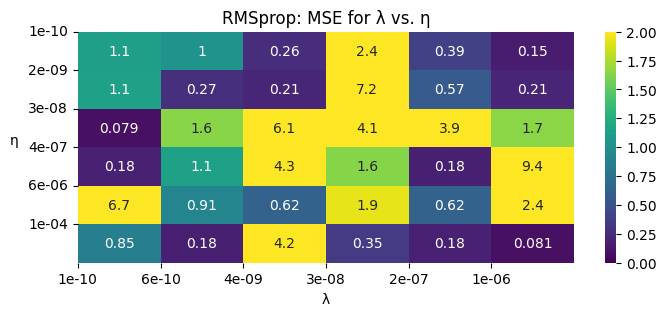

In [16]:
network.reset()
network.create_layers()

## Gradient Descent setup
num_param = 6
eta = anp.logspace(-10,-4,num_param)
lmbda = anp.logspace(-10,-6,num_param); lp = 2
decay_rms = 0.9

batches = 32; epoch = 1000

MSE_NN = anp.zeros((len(eta),len(lmbda)))
for i in range(len(eta)):
    for j in range(len(lmbda)):
        ## Recreating the layers
        network.create_layers()
        
        ## Calling GDMethod with new parameters
        GDMethod = RMSprop(eta[i],decay=decay_rms,lmbda=lmbda[j])

        network.train_network(inputs_train_s,targets_train,GDMethod,batches=batches,epochs=epoch)

        final_predict = network.feed_forward(inputs_test_s)
        
        MSE_NN[i,j] = mse_predict(final_predict,targets_test)
        if show == True:
            print(f'Method: {GDMethod.__class__.__name__}')
            print('Regularization, λ:',lmbda[j])
            print('Learning rate,  η:',eta[i])
            print('MSE: ',mse_predict(final_predict,targets_test))

        network.reset()

#MSE_NN = anp.nan_to_num(MSE_NN,nan=1)

fig,ax = lambda_eta(MSE_NN,[lmbda,eta],
                    axis_tick_labels=[[f'{y:.0e}' for y in lmbda],[f'{y:.0e}' for y in eta]],
                    cbar_lim=[0.,2.]
                    )
_ = ax.set_title(f'{GDMethod.__class__.__name__}: MSE for λ vs. η')#\nγ = %.0e'%(gamma))

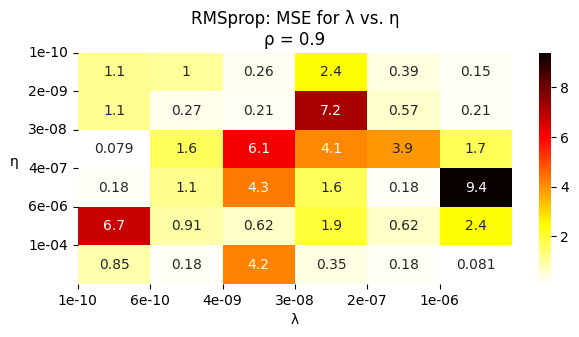

In [18]:
fig,ax = lambda_eta(MSE_NN,[lmbda,eta],
                    axis_tick_labels=[[f'{y:.0e}' for y in lmbda],[f'{y:.0e}' for y in eta]],
                    cbar_lim=[MSE_NN.min(),MSE_NN.max()],
                    #cbar_lim=[0.0,4.],
                    cmap='hot_r'#,save=True,f_name='grid_search_eta_lamb_ADAM_linreg.png'  #hot
                    )
fig.set_size_inches(7,3)
#ax.set_xlabel('ρ')
_ = ax.set_title(f'{GDMethod.__class__.__name__}: MSE for λ vs. η\nρ = %g'%(decay_rms))  #ρ = (%g, %g)' %(ADAM_decay[0],ADAM_decay[1]))

In [19]:
fig.savefig('grid_search_eta_lmbda_rms_linreg_m32_e1000_med_range.png',dpi=300,bbox_inches='tight')

#### Adaptive learning rate parameter for `RMSprop`-method

In [ ]:
network.reset()
network.create_layers()

## Gradient Descent setup
num_param = 5
eta = 1e-5
gamma = 1e-8
lmbda = 1e-8; lp = 2
adagrad_mom = gamma
decay_rms = anp.linspace(1e-6,0.9,num_param)
ADAM_decay1 = anp.linspace(1e-2,0.9,num_param)
ADAM_decay = [0.9, 0.99]

batches = 32; epoch = 1000

MSE_NN = anp.zeros((len(eta),len(lmbda)))
for i in range(len(eta)):
    for j in range(len(lmbda)):
        ## Recreating the layers
        network.create_layers()
        
        ADAM_decay[0] = ADAM_decay1[j] 
        ## Calling GDMethod with new parameters
        #GDMethod = PlainGD(eta[i],lmbda=lmbda[j],lp=lp)
        #GDMethod = MomentumGD(eta[i],gamma,lmbda=lmbda[j],lp=lp)
        #GDMethod = Adagrad(eta[i],adagrad_mom,lmbda=lmbda[j],lp=lp)
        GDMethod = RMSprop(eta[i],decay=decay_rms,lmbda=lmbda[j])
        #GDMethod = ADAM(eta[i],ADAM_decay,lmbda=lmbda[j])

        network.train_network(inputs_train_s,targets_train,GDMethod,batches=batches,epochs=epoch)

        final_predict = network.feed_forward(inputs_test_s)
        
        MSE_NN[i,j] = mse_predict(final_predict,targets_test)
        if show == True:
            print(f'Method: {GDMethod.__class__.__name__}')
            print('Regularization, λ:',lmbda[j])
            print('Learning rate,  η:',eta[i])
            print('MSE: ',mse_predict(final_predict,targets_test))

        network.reset()

#MSE_NN = anp.nan_to_num(MSE_NN,nan=1)

fig,ax = lambda_eta(MSE_NN,[lmbda,eta],
                    axis_tick_labels=[[f'{y:.0e}' for y in lmbda],[f'{y:.0e}' for y in eta]],
                    cbar_lim=[0.,2.]
                    )
_ = ax.set_title(f'{GDMethod.__class__.__name__}: MSE for λ vs. η')#\nγ = %.0e'%(gamma))

In [ ]:
fig,ax = lambda_eta(MSE_NN,[lmbda,eta],
                    axis_tick_labels=[[f'{y:.0e}' for y in lmbda],[f'{y:.0e}' for y in eta]],
                    cbar_lim=[MSE_NN.min(),MSE_NN.max()],
                    #cbar_lim=[0.0,4.],
                    cmap='viridis'#,save=True,f_name='grid_search_eta_lamb_ADAM_linreg.png'  #hot
                    )
fig.set_size_inches(7,3)
#ax.set_xlabel('ρ')
_ = ax.set_title(f'{GDMethod.__class__.__name__}: MSE for λ vs. η\nρ = (%g, %g)' %(ADAM_decay[0],ADAM_decay[1]))

In [ ]:
fig.savefig('grid_search_eta_decay_rms_linreg_m32_e1000.png',dpi=300,bbox_inches='tight')

In [ ]:
network.reset()
network.create_layers()

## Gradient Descent setup
num_param = 5
eta = 1e-5
gamma = 1e-8
lmbda = 1e-8; lp = 2
adagrad_mom = gamma
decay_rms = anp.linspace(1e-6,0.9,num_param)
ADAM_decay1 = anp.linspace(1e-2,0.9,num_param)
ADAM_decay = [0.9, 0.99]

batches = 32; epoch = 1000

MSE_NN = anp.zeros((len(eta),len(lmbda)))
for i in range(len(eta)):
    for j in range(len(lmbda)):
        ## Recreating the layers
        network.create_layers()
        
        ADAM_decay[0] = ADAM_decay1[j] 
        ## Calling GDMethod with new parameters
        #GDMethod = PlainGD(eta[i],lmbda=lmbda[j],lp=lp)
        #GDMethod = MomentumGD(eta[i],gamma,lmbda=lmbda[j],lp=lp)
        #GDMethod = Adagrad(eta[i],adagrad_mom,lmbda=lmbda[j],lp=lp)
        GDMethod = RMSprop(eta[i],decay=decay_rms,lmbda=lmbda[j])
        #GDMethod = ADAM(eta[i],ADAM_decay,lmbda=lmbda[j])

        network.train_network(inputs_train_s,targets_train,GDMethod,batches=batches,epochs=epoch)

        final_predict = network.feed_forward(inputs_test_s)
        
        MSE_NN[i,j] = mse_predict(final_predict,targets_test)
        if show == True:
            print(f'Method: {GDMethod.__class__.__name__}')
            print('Regularization, λ:',lmbda[j])
            print('Learning rate,  η:',eta[i])
            print('MSE: ',mse_predict(final_predict,targets_test))

        network.reset()

#MSE_NN = anp.nan_to_num(MSE_NN,nan=1)

fig,ax = lambda_eta(MSE_NN,[lmbda,eta],
                    axis_tick_labels=[[f'{y:.0e}' for y in lmbda],[f'{y:.0e}' for y in eta]],
                    cbar_lim=[0.,2.]
                    )
_ = ax.set_title(f'{GDMethod.__class__.__name__}: MSE for λ vs. η')#\nγ = %.0e'%(gamma))

In [ ]:
fig,ax = lambda_eta(MSE_NN,[lmbda,eta],
                    axis_tick_labels=[[f'{y:.0e}' for y in lmbda],[f'{y:.0e}' for y in eta]],
                    cbar_lim=[MSE_NN.min(),MSE_NN.max()],
                    #cbar_lim=[0.0,4.],
                    cmap='viridis'#,save=True,f_name='grid_search_eta_lamb_ADAM_linreg.png'  #hot
                    )
fig.set_size_inches(7,3)
#ax.set_xlabel('ρ')
_ = ax.set_title(f'{GDMethod.__class__.__name__}: MSE for λ vs. η\nρ = (%g, %g)' %(ADAM_decay[0],ADAM_decay[1]))

In [ ]:
fig.savefig('grid_search_eta_decay_adam_decay_m32_e1000.png',dpi=300,bbox_inches='tight')